# Portfolio Optimization using Monte Carlo Simulation

In volatile financial markets, efficient portfolio optimization is crucial for achieving the desired risk-return objectives. This study proposes a novel approach that combines parallel Monte Carlo simulations and Markowitz optimization to address the challenges of large portfolios and complex market dynamics. By leveraging the power of parallel computing, this approach significantly accelerates Monte Carlo simulations, enabling efficient exploration of the efficient frontier. This leads to several advantages, including scalability for large portfolios, robustness in accounting for market uncertainties, employing historical data for accurate risk and return models, and parallelization for faster and more informed decisions.

## Importing the required libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import joblib
from joblib import Parallel, delayed
import time

We will utilize the yfinance library to gather historical price data for assets such as Apple, Google, Microsoft, and others within a specified time frame.

# Fetching the stock data



In [2]:
# Function to fetch stock data from Yahoo Finance
def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Function to calculate returns and volatility
def calculate_returns_volatility(stocks):
    returns = np.log(stocks / stocks.shift(1))
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()
    return returns, mean_daily_returns, cov_matrix

In [3]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META']
start_date = '2002-01-01'
end_date = '2022-12-31'
num_portfolios = 30000

stock_data = get_stock_data(tickers, start_date, end_date)
returns, mean_daily_returns, cov_matrix = calculate_returns_volatility(stock_data)

[*********************100%%**********************]  6 of 6 completed


In [4]:
stock_data.head()

,AAPL,AMZN,GOOGL,META,MSFT,TSLA
Date,,,,,,
2002-01-02,0.352695,0.5480,NaN,NaN,20.781179,NaN
2002-01-03,0.356933,0.5950,NaN,NaN,21.460051,NaN
2002-01-04,0.358599,0.6125,NaN,NaN,21.357756,NaN
2002-01-07,0.346641,0.6170,NaN,NaN,21.252359,NaN
2002-01-08,0.342251,0.5925,NaN,NaN,21.506536,NaN


In [5]:
returns.head()

,AAPL,AMZN,GOOGL,META,MSFT,TSLA
Date,,,,,,
2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-03,0.011946,0.082286,NaN,NaN,0.032145,NaN
2002-01-04,0.004656,0.028988,NaN,NaN,-0.004778,NaN
2002-01-07,-0.033916,0.007320,NaN,NaN,-0.004947,NaN
2002-01-08,-0.012746,-0.040518,NaN,NaN,0.011889,NaN


In [6]:
mean_daily_returns

AAPL     0.001117
AMZN     0.000952
GOOGL    0.000770
META     0.000429
MSFT     0.000461
TSLA     0.001381
dtype: float64

In [7]:
cov_matrix

,AAPL,AMZN,GOOGL,META,MSFT,TSLA
AAPL,0.000474,0.000241,0.000213,0.000203,0.000201,0.000231
AMZN,0.000241,0.000669,0.000240,0.000255,0.000224,0.000265
GOOGL,0.000213,0.000240,0.000371,0.000233,0.000188,0.000208
META,0.000203,0.000255,0.000233,0.000647,0.000199,0.000260
MSFT,0.000201,0.000224,0.000188,0.000199,0.000314,0.000212
TSLA,0.000231,0.000265,0.000208,0.000260,0.000212,0.001286


In [8]:
# Function to perform Monte Carlo simulation
def monte_carlo_simulation(returns, mean_daily_returns, cov_matrix, num_portfolios):
    results = np.zeros((3, num_portfolios))
    weights_record = np.zeros((len(returns.columns), num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        results[2, i] = results[0, i] / results[1, i]
        weights_record[:, i] = weights
    
    return results, weights_record

In [9]:
# Perform Monte Carlo simulation - Sequential
start_time = time.time()
mc_results, mc_weights = monte_carlo_simulation(returns, mean_daily_returns, cov_matrix, num_portfolios)
end_time = time.time()
serial_time = end_time - start_time

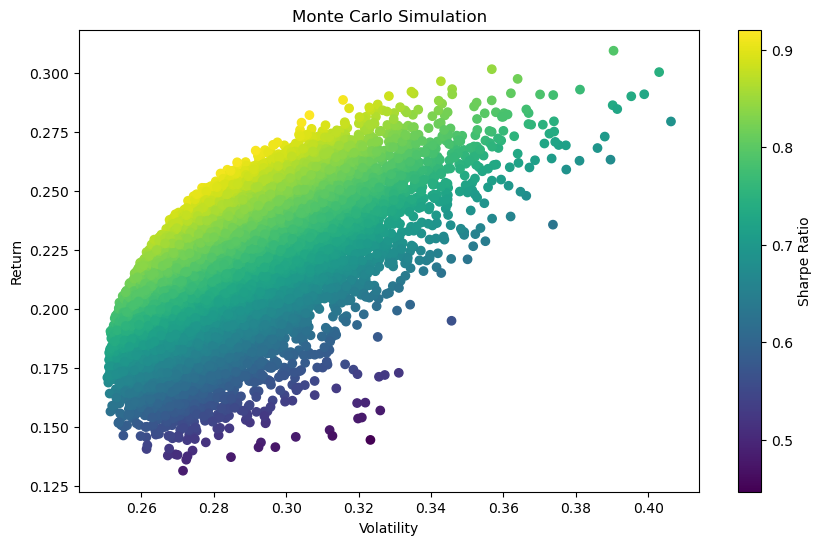

In [10]:
# Plotting Monte Carlo simulation results
plt.figure(figsize=(10, 6))
plt.scatter(mc_results[1, :], mc_results[0, :], c=mc_results[2, :], marker='o', cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.title('Monte Carlo Simulation')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [11]:
def simulate(i, returns, mean_daily_returns, cov_matrix):
    weights = np.random.random(len(returns.columns))
    weights /= np.sum(weights)
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return portfolio_return, portfolio_std_dev, i

In [12]:
# Perform Monte Carlo Simulation - Parallelization
n_jobs = joblib.cpu_count()

start_time = time.time()
results_parallel = Parallel(n_jobs=n_jobs)(delayed(simulate)(i, returns, mean_daily_returns, cov_matrix) for i in range(num_portfolios))

results_parallel = np.array(results_parallel).T
mc_results_joblib = results_parallel[:2]  # Extract return and volatility
mc_weights_joblib = np.zeros((results_parallel.shape[1], num_portfolios))
end_time = time.time()
parallel_time = end_time - start_time

In [13]:
# Function to calculate optimal portfolio using Markowitz method
def calculate_markowitz_portfolio(returns):
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def objective(weights):
        weights = np.array(weights)
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        return -portfolio_return / portfolio_std_dev

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    boundaries = tuple((0, 1) for _ in range(len(returns.columns)))
    init_guess = np.array(len(returns.columns) * [1. / len(returns.columns)])
    
    optimal_weights = minimize(objective, init_guess, method='SLSQP', bounds=boundaries, constraints=constraints)
    return optimal_weights


In [14]:
# Calculate Markowitz portfolio
optimal_weights = calculate_markowitz_portfolio(returns)

print("Optimal Allocation (Markowitz):")
print(optimal_weights.x)

Optimal Allocation (Markowitz):
[5.06957247e-01 1.28090741e-01 1.71765161e-01 2.57769067e-17
 0.00000000e+00 1.93186852e-01]


In [15]:
# Function to plot individual stocks
def plot_individual_stocks(returns):
    plt.figure(figsize=(12, 6))
    for c in returns.columns.values:
        plt.plot(returns.index, returns[c], lw=2, alpha=0.8, label=c)
    plt.legend(loc='upper left', fontsize=10)
    plt.title('Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Price')
    plt.show()

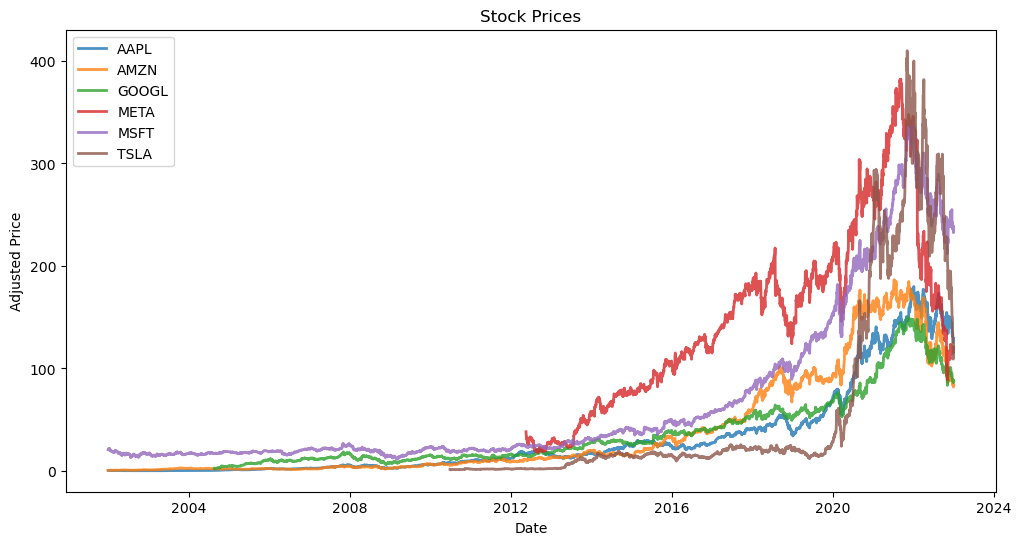

In [16]:
plot_individual_stocks(stock_data)

In [17]:
# Function to plot efficient frontier with Markowitz portfolio
def plot_efficient_frontier(returns, mean_daily_returns, cov_matrix, num_portfolios, optimal_weights):
    results, _ = monte_carlo_simulation(returns, mean_daily_returns, cov_matrix, num_portfolios)
    
    plt.scatter(results[1, :], results[0, :], c=results[2, :], marker='o', alpha=0.5, cmap='viridis', label='Monte Carlo')
    plt.plot(np.sqrt(np.diagonal(cov_matrix)) * np.sqrt(252), mean_daily_returns * 252, 'g*', markersize=15, label='Individual Stocks')
    plt.plot(np.sqrt(np.dot(optimal_weights.x.T, np.dot(cov_matrix, optimal_weights.x))) * np.sqrt(252), np.dot(optimal_weights.x.T, mean_daily_returns) * 252, 'r*', markersize=15, label='Markowitz Portfolio')
    plt.legend(loc='upper right')
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.show()


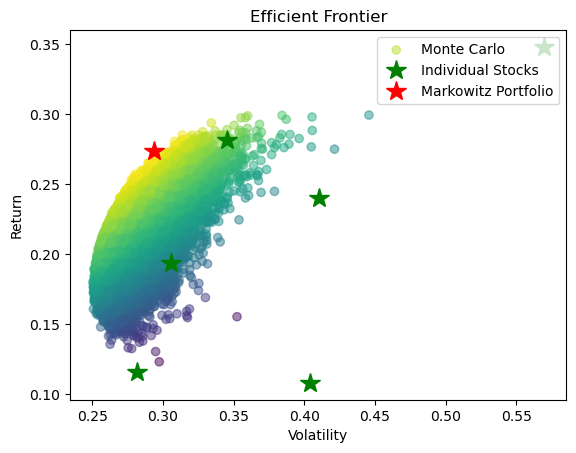

In [18]:
plot_efficient_frontier(returns, mean_daily_returns, cov_matrix, num_portfolios, optimal_weights)

In [19]:
# Time taken - Sequential
print(f"Time taken for Monte Carlo Simulation - Sequential: {serial_time:.2f}s")

# Time taken - parallelization
print(f"Time taken for Monte Carlo Simulation - Parallelization: {parallel_time:.2f}s")

# Calculate Speedup
speedup = serial_time / parallel_time

# Calculate Efficiency
efficiency = speedup / n_jobs

print(f"Speedup: {speedup:.2f}")
print(f"Efficiency: {efficiency:.2f}")

Time taken for Monte Carlo Simulation - Sequential: 6.45s
Time taken for Monte Carlo Simulation - Parallelization: 3.24s
Speedup: 1.99
Efficiency: 0.25
